<a href="https://colab.research.google.com/github/KeremAydin98/predicting-sunspots/blob/main/Predicting_sunspots_Dataset_window().ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv 

--2022-05-19 14:52:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘Sunspots.csv.1’

Sunspots.csv.1      100%[===================>]  69.17K  --.-KB/s    in 0s      

2022-05-19 14:52:53 (151 MB/s) - ‘Sunspots.csv.1’ saved [70827/70827]



In [26]:
import pandas as pd

df = pd.read_csv("Sunspots.csv", parse_dates=["Date"], index_col=["Date"])
df.head()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


In [27]:
df = df.drop("Unnamed: 0",axis=1)
df.head()

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [28]:
timesteps = df.index.to_numpy()
n_sunspots = df["Monthly Mean Total Sunspot Number"].to_numpy()

In [29]:
split_size = int(0.8 * len(n_sunspots))
train_sunspots, train_timesteps = n_sunspots[:split_size], timesteps[:split_size]
val_sunspots, val_timesteps = n_sunspots[split_size:], timesteps[split_size:]

In a window dataset, the previous n values could be seen as the input features. And the current value with any timestamp is the output label. window dataset consists of fixed window size.

In [30]:
train_sunspots.shape

(2588,)

In [31]:
import tensorflow as tf

In [32]:
def windowed_dataset(series, window_size, batch_size):

  series = tf.expand_dims(series, axis=-1)

  ds = tf.data.Dataset.from_tensor_slices(series)

  """
  Input:
  [[1,2,3,4,5,6,7]]
  Output:
  [[1,2,3,4,5],
  [2,3,4,5,6],
  [3,4,5,6,7]]
  """
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

  ds = ds.flat_map(lambda w: w.batch(window_size + 1))

  ds = ds.shuffle(1000)

  ds = ds.map(lambda w: (w[:-1],w[1:]))

  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [33]:
window_size = 7
batch_size = 32
train_dataset = windowed_dataset(train_sunspots,window_size=window_size, batch_size=batch_size)
val_dataset = windowed_dataset(val_sunspots,window_size=window_size, batch_size=batch_size)

In [34]:
# Create the model
inputs = tf.keras.layers.Input(shape=[None,1])

x = tf.keras.layers.Conv1D(64, 5, padding="causal",activation="relu")(inputs)

x = tf.keras.layers.LSTM(64, return_sequences=True, activation="relu")(x)

x = tf.keras.layers.LSTM(64, activation="relu")(x)

x = tf.keras.layers.Dense(32, activation="relu")(x)

outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.models.Model(inputs, outputs)

model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam())

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          384       
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,545
Trainable params: 68,545
Non-trainable

In [36]:
# Create checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint",
                                                         monitor="val_loss",
                                                         save_best_only=True)

In [37]:
history = model.fit(train_dataset, epochs=20,validation_data=val_dataset,callbacks=checkpoint_callback)

Epoch 1/20
     81/Unknown - 5s 36ms/step - loss: 25.0226INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 10s 103ms/step - loss: 25.0226 - val_loss: 15.1907
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 16.1717INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 20s 252ms/step - loss: 16.1717 - val_loss: 15.0629
Epoch 3/20
81/81 [==============================] - 6s 69ms/step - loss: 15.9168 - val_loss: 15.1309
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 15.9134INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 12s 152ms/step - loss: 15.9134 - val_loss: 14.8193
Epoch 5/20
81/81 [==============================] - ETA: 0s - loss: 15.7762INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 6s 75ms/step - loss: 15.7762 - val_loss: 14.7988
Epoch 6/20
81/81 [==============================] - ETA: 0s - loss: 15.8430INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 6s 79ms/step - loss: 15.8430 - val_loss: 14.7286
Epoch 7/20
81/81 [==============================] - 3s 37ms/step - loss: 15.7058 - val_loss: 14.7296
Epoch 8/20
81/81 [==============================] - 3s 37ms/step - loss: 15.6683 - val_loss: 14.7674
Epoch 9/20
81/81 [==============================] - 3s 36ms/step - loss: 15.7037 - val_loss: 14.8633
Epoch 10/20
81/81 [==============================] - 3s 37ms/step - loss: 15.7475 - val_loss: 14.8710
Epoch 11/20
81/81 [==============================] - 3s 37ms/step - loss: 15.6273 - val_loss: 14.8178
Epoch 12/20
81/81 [==============================] - 3s 36ms/step - loss: 15.6439 - val_loss: 14.7513
Epoch 13/20
81/81 [==============================] - 3s 36ms/step - loss: 15.6370 - val_loss: 14.7375
Epoch 14/20
81/81 [==============================] - 3s 37ms/step - loss: 15.6891 - val_loss: 15.0457
Epoch 15/20
80/81 [============================>.] - ETA: 0s - loss: 15.6103INFO:tensorflow:Asset

INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 6s 75ms/step - loss: 15.5995 - val_loss: 14.6758
Epoch 16/20
80/81 [============================>.] - ETA: 0s - loss: 15.5699INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 6s 78ms/step - loss: 15.5807 - val_loss: 14.6692
Epoch 17/20
81/81 [==============================] - 3s 37ms/step - loss: 15.5573 - val_loss: 14.7207
Epoch 18/20
81/81 [==============================] - 3s 36ms/step - loss: 15.5558 - val_loss: 14.8536
Epoch 19/20
81/81 [==============================] - 4s 45ms/step - loss: 15.5909 - val_loss: 14.6720
Epoch 20/20
81/81 [==============================] - ETA: 0s - loss: 15.5678INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


81/81 [==============================] - 6s 76ms/step - loss: 15.5678 - val_loss: 14.6369


In [38]:
model.evaluate(val_dataset)

20/20 [==============================] - 0s 6ms/step - loss: 14.6369


14.636947631835938

In [ ]:
model = tf.keras.models.load_model("/content/checkpoint")

In [40]:
model.evaluate(val_dataset)

20/20 [==============================] - 1s 7ms/step - loss: 14.6369


14.636947631835938

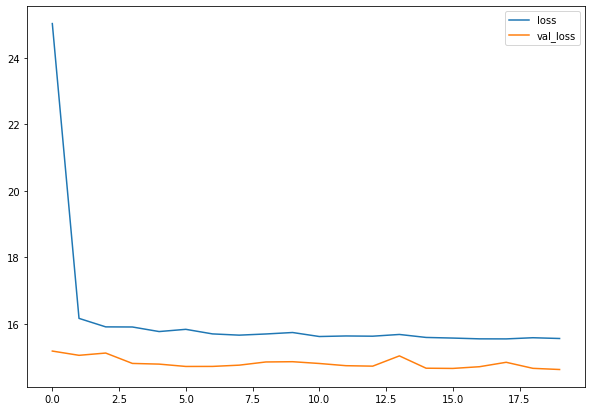

In [41]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.show()

In [42]:
def model_forecast(series, window_size, batch_size,model):

  series = tf.expand_dims(series, axis=-1)

  ds = tf.data.Dataset.from_tensor_slices(series)

  """
  Input:
  [[1,2,3,4,5,6,7]]
  Output:
  [[1,2,3,4,5],
  [2,3,4,5,6],
  [3,4,5,6,7]]
  """
  ds = ds.window(window_size, shift=1, drop_remainder=True)

  ds = ds.flat_map(lambda w: w.batch(window_size))

  ds = ds.batch(32).prefetch(1)

  prediction = model.predict(ds)

  return prediction

In [45]:
forecast = model_forecast(val_sunspots,window_size=window_size, batch_size=batch_size,model=model)
forecast.shape

(641, 1)

In [46]:
def plot_time_series(timesteps, values, start=None, end=None, format="-",label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  if label:
    plt.legend()

In [47]:
val_timesteps.shape, val_sunspots.shape

((647,), (647,))

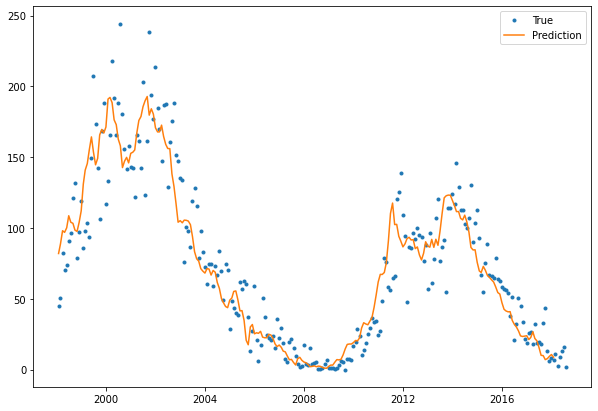

In [50]:
plt.figure(figsize=(10,7))
plot_time_series(val_timesteps,val_sunspots,start=400,format=".",label="True")
plot_time_series(val_timesteps[:-window_size+1],forecast[:,0],format="-", start=400,label="Prediction")
plt.show()